In [1]:
import operator
import sys
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg 
import time 
import pandas as pd
import random
from pyspark import mllib
from sklearn.linear_model import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from sklearn.model_selection import train_test_split
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression, OneVsRest

In [2]:
conf = SparkConf()
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### 1. Data loading

In [3]:
#Read csv file to dataframe
DATA_PATH = "gs://eecs6893-homework1/adult.csv"
df3 = spark.read.csv(DATA_PATH, inferSchema='true')
df3.show(3)

+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-----+------+----+----+--------------+------+
|_c0|              _c1|     _c2|       _c3| _c4|                _c5|               _c6|           _c7|   _c8|  _c9|  _c10|_c11|_c12|          _c13|  _c14|
+---+-----------------+--------+----------+----+-------------------+------------------+--------------+------+-----+------+----+----+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|13.0|      Never-married|      Adm-clerical| Not-in-family| White| Male|2174.0| 0.0|40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|13.0| Married-civ-spouse|   Exec-managerial|       Husband| White| Male|   0.0| 0.0|13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad| 9.0|           Divorced| Handlers-cleaners| Not-in-family| White| Male|   0.0| 0.0|40.0| United-States| <=50K|
+---+-----------------+--------+----------+----+-------------------+--

In [4]:
from functools import reduce

In [5]:
#change the column names of dataframe
df = df3.withColumnRenamed('_c0','age').withColumnRenamed('_c1','workclass').withColumnRenamed('_c2','fnlwgt')\
.withColumnRenamed('_c3', 'education').withColumnRenamed('_c4', 'education_num')\
.withColumnRenamed('_c5','marital_status').withColumnRenamed('_c6', 'occupation').withColumnRenamed('_c7', 'relationship')\
.withColumnRenamed('_c8', 'race').withColumnRenamed('_c9', 'sex').withColumnRenamed('_c10', 'capital_gain')\
.withColumnRenamed('_c11', 'capital_loss').withColumnRenamed('_c12','hours_per_week')\
.withColumnRenamed('_c13', 'native_country').withColumnRenamed('_c14', 'income')

df.printSchema()
df.show(2)

dataset = df

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)

+---+-----------------+-------+----------+-------------+-------------------+----------------+--------------+------+-----+------------+------------+--------------+--------------+------+
|age|        workclass| fnlwgt| education|education_num|     marital_status|      occupation|  relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+-

### 2. Data preprocessing

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [7]:
#stages in our Pipeline
stages = []
categoricalColumns = ["workclass","education","marital_status","occupation","relationship","race","sex","native_country"]

In [8]:
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [9]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [10]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [11]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(dataset)
preppedDataDF = pipelineModel.transform(dataset)

In [12]:
preppedDataDF.take(3)

21/10/20 18:26:40 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(age=39, workclass=' State-gov', fnlwgt=77516.0, education=' Bachelors', education_num=13.0, marital_status=' Never-married', occupation=' Adm-clerical', relationship=' Not-in-family', race=' White', sex=' Male', capital_gain=2174.0, capital_loss=0.0, hours_per_week=40.0, native_country=' United-States', income=' <=50K', workclassIndex=4.0, workclassclassVec=SparseVector(8, {4: 1.0}), educationIndex=2.0, educationclassVec=SparseVector(15, {2: 1.0}), marital_statusIndex=1.0, marital_statusclassVec=SparseVector(6, {1: 1.0}), occupationIndex=3.0, occupationclassVec=SparseVector(14, {3: 1.0}), relationshipIndex=1.0, relationshipclassVec=SparseVector(5, {1: 1.0}), raceIndex=0.0, raceclassVec=SparseVector(4, {0: 1.0}), sexIndex=0.0, sexclassVec=SparseVector(1, {0: 1.0}), native_countryIndex=0.0, native_countryclassVec=SparseVector(41, {0: 1.0}), label=0.0, features=SparseVector(100, {4: 1.0, 10: 1.0, 24: 1.0, 32: 1.0, 44: 1.0, 48: 1.0, 52: 1.0, 53: 1.0, 94: 39.0, 95: 77516.0, 96: 13.0, 9

In [13]:
# Keep relevant columns
cols = dataset.columns

selectedcols = ["label", "features"] + cols
#selectedcols = ["label", "features"]
dataset = preppedDataDF.select(selectedcols)
display(dataset)

DataFrame[label: double, features: vector, age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

In [14]:
preppedDataDF.head()

Row(age=39, workclass=' State-gov', fnlwgt=77516.0, education=' Bachelors', education_num=13.0, marital_status=' Never-married', occupation=' Adm-clerical', relationship=' Not-in-family', race=' White', sex=' Male', capital_gain=2174.0, capital_loss=0.0, hours_per_week=40.0, native_country=' United-States', income=' <=50K', workclassIndex=4.0, workclassclassVec=SparseVector(8, {4: 1.0}), educationIndex=2.0, educationclassVec=SparseVector(15, {2: 1.0}), marital_statusIndex=1.0, marital_statusclassVec=SparseVector(6, {1: 1.0}), occupationIndex=3.0, occupationclassVec=SparseVector(14, {3: 1.0}), relationshipIndex=1.0, relationshipclassVec=SparseVector(5, {1: 1.0}), raceIndex=0.0, raceclassVec=SparseVector(4, {0: 1.0}), sexIndex=0.0, sexclassVec=SparseVector(1, {0: 1.0}), native_countryIndex=0.0, native_countryclassVec=SparseVector(41, {0: 1.0}), label=0.0, features=SparseVector(100, {4: 1.0, 10: 1.0, 24: 1.0, 32: 1.0, 44: 1.0, 48: 1.0, 52: 1.0, 53: 1.0, 94: 39.0, 95: 77516.0, 96: 13.0, 97

In [15]:
dataset.head()

Row(label=0.0, features=SparseVector(100, {4: 1.0, 10: 1.0, 24: 1.0, 32: 1.0, 44: 1.0, 48: 1.0, 52: 1.0, 53: 1.0, 94: 39.0, 95: 77516.0, 96: 13.0, 97: 2174.0, 99: 40.0}), age=39, workclass=' State-gov', fnlwgt=77516.0, education=' Bachelors', education_num=13.0, marital_status=' Never-married', occupation=' Adm-clerical', relationship=' Not-in-family', race=' White', sex=' Male', capital_gain=2174.0, capital_loss=0.0, hours_per_week=40.0, native_country=' United-States', income=' <=50K')

In [16]:
train, test = dataset.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 22828


Test Dataset Count: 9733


### 3. Modeling

In [38]:
dict_accuracy = {}

### Logistic Regressions

In [50]:
# Fit model to prepped data

#LogisticRegression model, maxIter=10
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

# select example rows to display
predictions = lrModel.transform(test)
predictions.show(5)

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

dict_accuracy.update({"Logistic Regressions": accuracy})

+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|  fnlwgt|education|education_num|     marital_status|     occupation|relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(100,[0,8,23,29,4...| 47|  Private|185385.0|  HS-grad|          9.0| Married-civ-spouse| Prof-specialty|     Husband| White| Male|      5013.0|         0.0|          24.0| United-States| <=50K|[-0.0696165789154...|[0.48260288091883

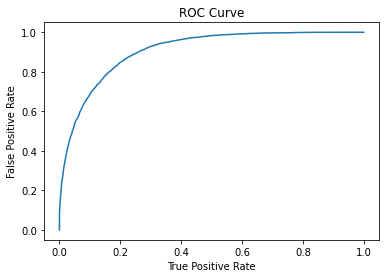

Training set areaUnderROC: 0.9063357884140066


In [18]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [19]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9030800588536182


### Random Forest

In [44]:
#Random Forest
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.show(5)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
dict_accuracy.update({"Random Forest": accuracy})

+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|  fnlwgt|education|education_num|     marital_status|     occupation|relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(100,[0,8,23,29,4...| 47|  Private|185385.0|  HS-grad|          9.0| Married-civ-spouse| Prof-specialty|     Husband| White| Male|      5013.0|         0.0|          24.0| United-States| <=50K|[12.6540020728788...|[0.63270010364394

Test set accuracy = 0.8256447138600637


In [45]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8913032587085269


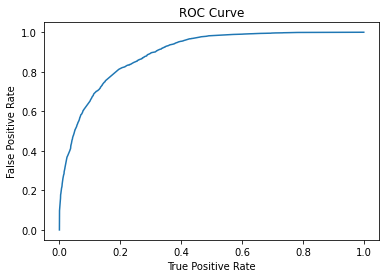

Training set areaUnderROC: 0.8936285737257895


In [46]:
trainingSummary = rfModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Naive Bayes

In [47]:
nb = NaiveBayes(modelType="multinomial")
nbmodel = nb.fit(train)
predictions_df = nbmodel.transform(test)
predictions_df.show(5, True)

+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+-----------+----------+
|label|            features|age|workclass|  fnlwgt|education|education_num|     marital_status|     occupation|relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|probability|prediction|
+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+-----------+----------+
|  0.0|(100,[0,8,23,29,4...| 47|  Private|185385.0|  HS-grad|          9.0| Married-civ-spouse| Prof-specialty|     Husband| White| Male|      5013.0|         0.0|          24.0| United-States| <=50K|[-36946.935806598...|  [0.0,1.0]|       1.0|
|  0.0|(100,[0,8,23,

In [51]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(predictions_df) 
print("Test accuracy = " + str(nbaccuracy))
dict_accuracy.update({"Naive Bayes": nbaccuracy})
print(dict_accuracy)

Test accuracy = 0.7809514024452893
{'Logistic Regressions': 0.8487619439021884, 'Random Forest': 0.8256447138600637, 'Naive Bayes': 0.7809514024452893}


### Decision Trees

In [52]:
#Decision Tree

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.show(5)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
dict_accuracy.update({"Decision Trees": accuracy})

+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+---------------+--------------------+----------+
|label|            features|age|workclass|  fnlwgt|education|education_num|     marital_status|     occupation|relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|  rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+---------------+--------------------+----------+
|  0.0|(100,[0,8,23,29,4...| 47|  Private|185385.0|  HS-grad|          9.0| Married-civ-spouse| Prof-specialty|     Husband| White| Male|      5013.0|         0.0|          24.0| United-States| <=50K|  [149.0,400.0]|[0.27140255009107...|       1.0|
|  0

In [53]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7360338729318517


### Gradient Boosting Trees

In [55]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
dict_accuracy.update({"Gradient Boosting Trees": accuracy})

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test set accuracy = 0.8487619439021884


Test Area Under ROC: 0.9064794240471198


### Multi-layer Perceptron

In [56]:
mlp = MultilayerPerceptronClassifier(featuresCol = 'features', labelCol = 'label' , maxIter = 10, layers = [100,5,4,2])
mlpmodel = mlp.fit(train)

# compute accuracy on the test set
predictions = mlpmodel.transform(test)
predictions.show(5)

evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol ="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
dict_accuracy.update({"Multi Layer Perceptron": accuracy})
print("Accuracy:" + str(accuracy))


+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|  fnlwgt|education|education_num|     marital_status|     occupation|relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(100,[0,8,23,29,4...| 47|  Private|185385.0|  HS-grad|          9.0| Married-civ-spouse| Prof-specialty|     Husband| White| Male|      5013.0|         0.0|          24.0| United-States| <=50K|[0.62454372295416...|[0.75472265660861

Accuracy:0.7566012534675846


In [57]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5002110595187843


### Linear SVM

In [58]:
# Linear Support Vector Machine

lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(train)

# Print the coefficients and intercept for linear SVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

# compute accuracy on the test set
predictions = lsvcModel.transform(test)
predictions.show(5)

evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol ="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
dict_accuracy.update({"Linear SVM": accuracy})
print("Accuracy:" + str(accuracy))

Coefficients: [-0.08987673431369109,-0.1526745599772933,-0.1257199500163813,-0.1274052864624474,-0.09667834929010222,0.31554232463823184,0.016129564654024403,-0.21606139740787803,-0.22566098886561378,-0.12538625979655502,0.1703368359935025,0.391807154333066,-0.04415363922329063,-0.23742307727482392,-0.022895757194524944,-0.2518075757868201,-0.3411785232745537,0.7706174200326091,-0.2956429523816542,-0.1810190312879053,0.7941238115372615,-0.3298897955656028,-0.4501737810982235,0.05954009567461356,-0.2999607557021675,-0.15692380077259513,-0.18193250293578667,-0.09210608386022229,-0.2514049836831635,0.1367904097501856,-0.18778604447182445,0.23300444073381651,-0.10897742861282994,0.0,-0.18337573716349134,-0.21061508383098895,-0.12855273658672978,-0.19855052348556884,-0.23426781100929114,-0.2845216666215242,0.009035931732954678,-0.05341881430737881,-0.18994803371773394,0.1321621284565398,-0.1336330565986762,-0.25345862021363297,-0.194896008668666,0.07423926690801541,-0.12981887062296113,-0.1

+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+----------+
|label|            features|age|workclass|  fnlwgt|education|education_num|     marital_status|     occupation|relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|prediction|
+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+----------+
|  0.0|(100,[0,8,23,29,4...| 47|  Private|185385.0|  HS-grad|          9.0| Married-civ-spouse| Prof-specialty|     Husband| White| Male|      5013.0|         0.0|          24.0| United-States| <=50K|[0.50060906864813...|       0.0|
|  0.0|(100,[0,8,23,29,4...| 31|  Private| 62374.0|  HS-grad|       

Accuracy:0.7973903215863557


In [60]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8707088481515582


### One-vs-Rest

In [63]:
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions = ovrModel.transform(test)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Accuracy: " + str(accuracy))
#print("Test Error = %g" % (1.0 - accuracy))
dict_accuracy.update({"One-vs-Rest": accuracy})


Accuracy: 0.8487619439021884
Test Error = 0.151238


### Comparison and analysis

The accuracy and auc metric have been calculated baove under each model.
The comparison is done below:

In [69]:
# Rank models according to Test set accuracy
sort_orders = sorted(dict_accuracy.items(), key=lambda x: x[1], reverse=True)

for i in sort_orders:
    print(i[0], i[1])

Logistic Regressions 0.8487619439021884
Gradient Boosting Trees 0.8487619439021884
One-vs-Rest 0.8487619439021884
Decision Trees 0.8377684167266002
Random Forest 0.8256447138600637
Linear SVM 0.7973903215863557
Naive Bayes 0.7809514024452893
Multi Layer Perceptron 0.7566012534675846


In order to compare the different models being used, I saved the accuracy of each model into a dictionary and then sorted it. As we can see, the Logistic regressions model performs best followed by Gradient Boosting Trees and One-vs-rest. Generally, we would expect MLPs to perform best, however, since we have not performed hyperparameter tuning, it performed comparitively poorly. 